# Reinforcement learning

I'm gonna try a real simple RL task: solve cartpole with a DQN.

In [1]:
import math
import random
from collections import namedtuple
from itertools import count
from PIL import Image
import time
import multiprocessing as mp

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as T

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

In [2]:
# definitely want to do this on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Environment

In [3]:
# Create the cartpole environment
# .unwrapped exposes some behind-the-scenes options of the environment
env = gym.make('CartPole-v0').unwrapped

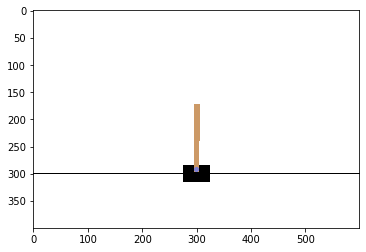

In [4]:
# Running this cell will open a window displaying the environment visually
env.reset()
img = env.render(mode='rgb_array')
env.close() # This closes the window
plt.imshow(img)
plt.show()

## Replay memory

Replay memory is very important in deep RL because it allows
1. data reuse
2. breaks the temporal correlation between samples
3. speeds up GPU operations because value function learning can be batched

In [5]:
Transition = namedtuple("Transition",
    ('state','action','next_state','reward'))

class ReplayMemory:
    """The replay memory."""
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
        
    def push(self, *args):
        """Saves a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## DQN algorithm

In a nutshell, the DQN (Deep Q-Network) algorithm is a basic Q-learning algorithm, where a neural network is used to approximate the action-value function $Q(s,a)$ (also called the Q-value, Q-function, etc.), which describes the expected future value of taking action $a$ in state $s$. The policy $\pi(s)$ is simply the action that gives us the most value from the state $s$:
$$\pi(s) = \underset{a}{\text{argmax}} Q(s,a)$$
The Q-value should obey the Bellman equation, which relates the Q-values of successive states:
$$Q_\pi(s,a) = r + \gamma Q_\pi(s^\prime, \pi(s^\prime)),$$
where $r$ is the reward gathered during the state transition $s \rightarrow s^\prime$, and $0 < \gamma \le 1$ is the "discount factor" (it encapsulates the idea that future rewards are worth less in the present).

The way our DQN is going to work is that we will use a neural network to approximate $Q$, then ensure that it satisfies the Bellman equation by minimizing the error
$$ \delta = Q(s,a) - (r + \gamma \underset{a}{\max} Q(s^\prime,a))$$.
Our loss function will be calculated using the Huber loss, averaged over a batch of transitions $B$ sampled from the replay memory
$$
\mathcal{L} = \frac{1}{|B|} \sum_{(s,a,s^\prime,r)\in B} \mathcal{L}(\delta) \\
\text{where}\quad
\mathcal{L}(\delta) = \begin{cases}
\tfrac{1}{2}\delta^2 & \text{for } |\delta| \le 1 \\
|\delta| - \tfrac{1}{2} & \text{otherwise}
\end{cases}
$$
The Huber loss is supposedly more robust to outliers because the loss is linear rather than quadratic for $|\delta| > 1$

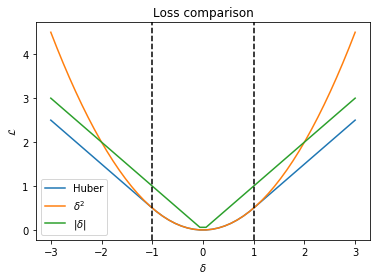

In [6]:
x = np.linspace(-3, 3, 50)
y = np.array([
    0.5*(d**2) if abs(d) <= 1 else abs(d)-0.5 for d in x
])

plt.plot(x, y, label='Huber')
plt.plot(x, 0.5*x**2, label='$\delta^2$')
plt.plot(x, abs(x), label='$|\delta|$')

plt.axvline(-1, color='black', linestyle='--')
plt.axvline(+1, color='black', linestyle='--')
plt.title("Loss comparison")
plt.xlabel("$\delta$")
plt.ylabel("$\mathcal{L}$")
plt.legend()
plt.show()

## Q-network

Here we will construct the DQN model.

In [7]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Number of Linear input size depends on output of conv2d
        def size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size-1) - 1) // stride + 1
        convw = size_out(size_out(size_out(w)))
        convh = size_out(size_out(size_out(h)))
        input_size = convw * convh * 32
        self.head = nn.Linear(input_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Input extraction

In [8]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.CUBIC),
    T.ToTensor()
])

def get_cart_location(screen_width):
    """Returns the position of the middle of the cart"""
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width/2.0)



def get_screen():
    # Returned screen requested by gym is (400, 600, 3), but is sometimes larger
    # such as (800, 1200, 3). Transpose it into torch order (CHW)
    screen = env.render(mode='rgb_array')
    env.close()
    screen = screen.transpose((2, 0, 1))
    
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width//2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32)/255
    screen = torch.from_numpy(screen)
    # Resize and add a batch dimension
    return resize(screen).unsqueeze(0).to(device)

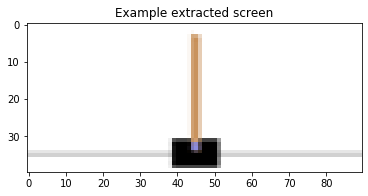

In [10]:
env.reset()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title("Example extracted screen")
plt.show()

## Training

In [11]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [12]:
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=512, out_features=2, bias=True)
)

In [13]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10_000)

In [14]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device,
                            dtype=torch.long)

In [15]:
episode_durations = []

def plot_durations():
    plt.figure()
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
#         display.display(plt.gcf())

## Training loop

In [16]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device,
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values,
                           expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

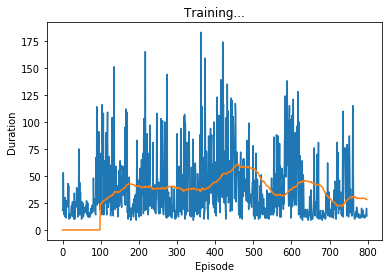

In [20]:
start_time = time.time()
i_episode = 0
while time.time() - start_time < 60*60:
    i_episode += 1
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        # Store transitions in memory
        memory.push(state, action, next_state, reward)
        
        # Move to next state
        state = next_state
        
        # Perform one step of optimization (on policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

## Conclusion

It seems that pytorch makes it very simple to construct complicated algorithms like Q-learning and run them almost entirely on the GPU. While this tutorial showed how this could be easily accomplished, the author's choice to use raw pixels as features (and the difference between frames, at that) is somewhat confusing, when much simpler features can be extracted from the environment without resorting to computer vision techniques.